In [1]:
# Requires: rdkit, pynndescent, numpy, scipy, scikit-learn
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFingerprintGenerator
from pynndescent import NNDescent
from scipy.sparse import coo_matrix
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans

# Load SMILES from ChEMBL dataset
df = pd.read_csv('datasets/chembl_pretraining.csv')
smiles = df['smiles'].tolist()

print("Step 1: Fingerprint per scaffold")
mols = [Chem.MolFromSmiles(s) for s in smiles]
scaff_to_idx = {}
for i, m in enumerate(mols):
    if m is None: continue
    scaf = MurckoScaffold.GetScaffoldForMol(m)
    if scaf is None or scaf.GetNumAtoms() == 0: continue
    scaf_smi = Chem.MolToSmiles(scaf, isomericSmiles=False)
    scaff_to_idx.setdefault(scaf_smi, []).append(i)

scaff_smis = list(scaff_to_idx.keys())
rep_idx = [v[0] for v in scaff_to_idx.values()]  # pick first molecule as representative
gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)
X = np.zeros((len(rep_idx), 2048), dtype=bool)
for r, i in enumerate(rep_idx):
    bv = gen.GetFingerprint(mols[i])
    on = list(bv.GetOnBits())
    if on: X[r, on] = True

print("Step 2 (updated): Fully connected Jaccard kernel (Nyström) + spectral clustering")
def jaccard_AB(A, B, chunk=2048):
    B_u16 = B.astype(np.uint16); B_t = B_u16.T
    bsum = B.sum(axis=1).astype(np.int32)
    n, m = A.shape[0], B.shape[0]
    out = np.empty((n, m), dtype=np.float32)
    for i in range(0, n, chunk):
        Ab = A[i:i+chunk]
        inter = Ab.astype(np.uint16) @ B_t
        asum = Ab.sum(axis=1).astype(np.int32)[:, None]
        union = asum + bsum[None, :] - inter
        union = np.maximum(union, 1)
        out[i:i+chunk] = inter / union
    return out

rng = np.random.default_rng(0)
n = X.shape[0]
m = min(1024, n)
L = rng.choice(n, size=m, replace=False)
B = X[L]
C = jaccard_AB(X, B, chunk=2048).astype(np.float32)
W = jaccard_AB(B, B, chunk=1024).astype(np.float32)
eps = 1e-6
evals, evecs = np.linalg.eigh(W + eps*np.eye(m, dtype=np.float32))
Winv = (evecs / evals) @ evecs.T
Winvsqrt = (evecs / np.sqrt(evals)) @ evecs.T
u = C.sum(axis=0)
v = Winv @ u
d = C @ v
s = (1.0 / np.sqrt(d + 1e-12)).astype(np.float32)
E = (C * s[:, None]) @ Winvsqrt
U, S, VT = randomized_svd(E, n_components=3, random_state=0)
Y = U / (np.linalg.norm(U, axis=1, keepdims=True) + 1e-12)
labels = KMeans(n_clusters=3, n_init=10, random_state=0).fit_predict(Y)

Step 1: Fingerprint per scaffold
Step 2 (updated): Fully connected Jaccard kernel (Nyström) + spectral clustering


In [2]:
# Identify multi-target scaffolds and protein activity patterns
from collections import defaultdict

protein_cols = [col for col in df.columns if col != 'smiles']
scaffold_proteins = defaultdict(set)
protein_scaffolds = defaultdict(set)

for i, row in df.iterrows():
    scaffold_idx = next((j for j, scaff_mols in enumerate([scaff_to_idx[s] for s in scaff_smis]) if i in scaff_mols), -1)
    if scaffold_idx == -1: continue
    scaffold = scaff_smis[scaffold_idx]
    
    for protein in protein_cols:
        if pd.notna(row[protein]):
            scaffold_proteins[scaffold].add(protein)
            protein_scaffolds[protein].add(scaffold)

multitarget_scaffolds = {s: proteins for s, proteins in scaffold_proteins.items() if len(proteins) > 1}
protein_scaffold_counts = {p: len(scaffolds) for p, scaffolds in protein_scaffolds.items()}
print(f"Multi-target scaffolds: {len(multitarget_scaffolds)} / {len(scaff_smis)}")
print(f"Proteins with <5 scaffolds: {sum(1 for c in protein_scaffold_counts.values() if c < 5)}")

Multi-target scaffolds: 10595 / 30935
Proteins with <5 scaffolds: 56


In [8]:
# Step 4: Protein-aware splitting
n = len(scaff_smis)
centroids = np.vstack([Y[labels==i].mean(axis=0) for i in range(3)])
d = np.linalg.norm(Y - centroids[labels], axis=1)
sizes = np.bincount(labels, minlength=3)
order = np.argsort(-sizes)
split_map = {order[0]:0, order[1]:1, order[2]:2}
split = np.array([split_map[l] for l in labels])
targets = (np.array([0.8,0.1,0.1])*n).astype(int); targets[0] = n - targets[1] - targets[2]

def rebalance(split, d, targets):
    while True:
        counts = np.bincount(split, minlength=3)
        diff = counts - targets
        if not (diff>0).any() or not (diff<0).any(): break
        s_over = np.argmax(np.where(diff>0, diff, -1))
        s_under = np.argmin(np.where(diff<0, diff,  n+1))
        k = min(diff[s_over], -diff[s_under])
        idx = np.where(split==s_over)[0]
        move = idx[np.argsort(-d[idx])[:k]]
        split[move] = s_under
    return split

split = rebalance(split, d, targets)

# Protein coverage adjustment
scaffold_to_idx_map = {s: i for i, s in enumerate(scaff_smis)}
problem_proteins = [p for p, count in protein_scaffold_counts.items() if count >= 10]

for protein in problem_proteins:
    scaffolds = list(protein_scaffolds[protein])
    scaffold_indices = [scaffold_to_idx_map[s] for s in scaffolds if s in scaffold_to_idx_map]
    
    if len([i for i in scaffold_indices if split[i] == 1]) == 0:  # No val scaffolds
        multitarget_candidates = [i for i in scaffold_indices if scaff_smis[i] in multitarget_scaffolds and split[i] == 0]
        if multitarget_candidates:
            split[multitarget_candidates[0]] = 1
    
    if len([i for i in scaffold_indices if split[i] == 2]) == 0:  # No test scaffolds
        multitarget_candidates = [i for i in scaffold_indices if scaff_smis[i] in multitarget_scaffolds and split[i] == 0]
        if multitarget_candidates:
            split[multitarget_candidates[0]] = 2

split = rebalance(split, d, targets)

scaff_mol_indices = [scaff_to_idx[s] for s in scaff_smis]
train_idx = [i for j in range(n) if split[j]==0 for i in scaff_mol_indices[j]]
val_idx   = [i for j in range(n) if split[j]==1 for i in scaff_mol_indices[j]]
test_idx  = [i for j in range(n) if split[j]==2 for i in scaff_mol_indices[j]]

train_scaff = set(np.where(split==0)[0]); val_scaff = set(np.where(split==1)[0]); test_scaff = set(np.where(split==2)[0])
print("Scaffold overlaps:", len(train_scaff & val_scaff), len(train_scaff & test_scaff), len(val_scaff & test_scaff))

rng = np.random.default_rng(0)
Xt, Xs = X[split==0], X[split==2]
def avg_tanimoto_pairs(A, B, m=79482):
    ai = rng.integers(len(A), size=m); bi = rng.integers(len(B), size=m)
    a, b = A[ai], B[bi]
    inter = np.logical_and(a, b).sum(axis=1)
    union = np.logical_or(a, b).sum(axis=1); union[union==0]=1
    return (inter/union).mean()

within_train = avg_tanimoto_pairs(Xt, Xt)
between_tt = avg_tanimoto_pairs(Xt, Xs)
print("Avg Tanimoto within-train:", float(within_train))
print("Avg Tanimoto train↔test:", float(between_tt))

Scaffold overlaps: 0 0 0
Avg Tanimoto within-train: 0.1027051162624553
Avg Tanimoto train↔test: 0.10151908372226309


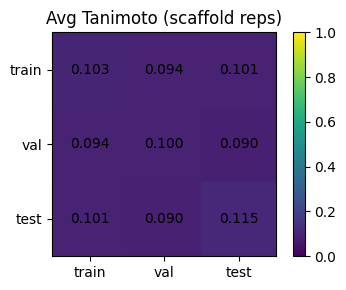

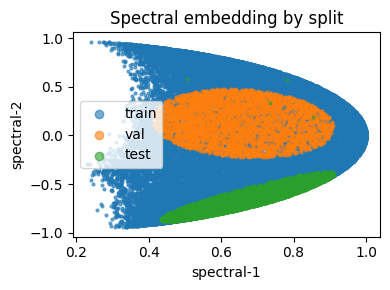

In [9]:
import numpy as np, matplotlib.pyplot as plt

# 3×3 Tanimoto heatmap (using scaffold representatives X and split labels 0=train,1=val,2=test)
rng = np.random.default_rng(0)
def avg_tanimoto_pairs(A, B, m=79482):
    ai = rng.integers(len(A), size=m); bi = rng.integers(len(B), size=m)
    a, b = A[ai], B[bi]
    inter = np.logical_and(a, b).sum(axis=1)
    union = np.logical_or(a, b).sum(axis=1); union[union==0]=1
    return (inter/union).mean()

M = np.zeros((3,3))
Xs = [X[split==i] for i in range(3)]
for i in range(3):
    for j in range(3):
        M[i,j] = avg_tanimoto_pairs(Xs[i], Xs[j]) if i!=j else avg_tanimoto_pairs(Xs[i], Xs[i])

plt.figure(figsize=(4,3))
plt.imshow(M, vmin=0, vmax=1)
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{M[i,j]:.3f}", ha="center", va="center")
plt.xticks([0,1,2], ["train","val","test"])
plt.yticks([0,1,2], ["train","val","test"])
plt.title("Avg Tanimoto (scaffold reps)")
plt.colorbar()
plt.tight_layout()
plt.show()

# 2D spectral scatter (use first two spectral components from Y)
plt.figure(figsize=(4,3))
for s,name in enumerate(["train","val","test"]):
    m = (split==s)
    plt.scatter(Y[m,0], Y[m,1], s=4, alpha=0.6, label=name)
plt.legend(markerscale=3)
plt.xlabel("spectral-1"); plt.ylabel("spectral-2"); plt.title("Spectral embedding by split")
plt.tight_layout()
plt.show()


Overlap scaffolds -> train∩val: 0  train∩test: 0  val∩test: 0
VAL→TRAIN NN Tanimoto: mean=0.263, p95=0.677, ≥0.40=20.6%, ≥0.50=15.7%, ≥0.60=9.3%
TEST→TRAIN NN Tanimoto: mean=0.263, p95=0.654, ≥0.40=18.8%, ≥0.50=13.7%, ≥0.60=8.1%
Avg Tanimoto: within-train=0.103, train↔val=0.094, train↔test=0.101, val↔test=0.090


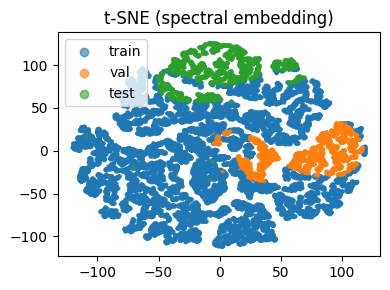

In [10]:
# Overlap & leakage stats + t-SNE (using scaffold reps X, spectral emb. Y, and split labels 0/1/2)

import numpy as np
from pynndescent import NNDescent
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1) Scaffold overlap (should be zero)
train_scaff = set(np.where(split==0)[0]); val_scaff = set(np.where(split==1)[0]); test_scaff = set(np.where(split==2)[0])
print("Overlap scaffolds -> train∩val:", len(train_scaff & val_scaff), " train∩test:", len(train_scaff & test_scaff), " val∩test:", len(val_scaff & test_scaff))

# 2) Nearest-neighbor leakage to TRAIN (scaffold level, Jaccard on binary ECFP reps)
rng = np.random.default_rng(0)
X_train, X_val, X_test = X[split==0], X[split==1], X[split==2]
idx_train = NNDescent(X_train, metric="jaccard", n_neighbors=1, random_state=0)
def nn_sim_to_train(Q):
    ind, dist = idx_train.query(Q, k=1)
    return 1.0 - dist.ravel()
val_sim = nn_sim_to_train(X_val); test_sim = nn_sim_to_train(X_test)
for name, sim in [("VAL", val_sim), ("TEST", test_sim)]:
    pct40 = (sim>=0.40).mean()*100; pct50 = (sim>=0.50).mean()*100; pct60 = (sim>=0.60).mean()*100
    print(f"{name}→TRAIN NN Tanimoto: mean={sim.mean():.3f}, p95={np.percentile(sim,95):.3f}, ≥0.40={pct40:.1f}%, ≥0.50={pct50:.1f}%, ≥0.60={pct60:.1f}%")

# 3) Similarity gap (average Tanimoto within/between using scaffold reps; sampled)
def avg_tanimoto_pairs(A, B, m=79482, rng=rng):
    ai = rng.integers(len(A), size=m); bi = rng.integers(len(B), size=m)
    a, b = A[ai], B[bi]
    inter = np.logical_and(a, b).sum(axis=1)
    union = np.logical_or(a, b).sum(axis=1); union[union==0]=1
    return float((inter/union).mean())
def avg_tanimoto_within(A, m=79482, rng=rng):
    n = len(A); i = rng.integers(n, size=m); j = rng.integers(n, size=m); msk = i!=j
    a, b = A[i[msk]], A[j[msk]]
    inter = np.logical_and(a, b).sum(axis=1)
    union = np.logical_or(a, b).sum(axis=1); union[union==0]=1
    return float((inter/union).mean())
within_train = avg_tanimoto_within(X_train)
train_val = avg_tanimoto_pairs(X_train, X_val)
train_test = avg_tanimoto_pairs(X_train, X_test)
val_test = avg_tanimoto_pairs(X_val, X_test)
print(f"Avg Tanimoto: within-train={within_train:.3f}, train↔val={train_val:.3f}, train↔test={train_test:.3f}, val↔test={val_test:.3f}")

# 4) t-SNE on spectral embedding (subsample if large)
n = Y.shape[0]
keep = min(n, 79482)
idx = rng.choice(n, size=keep, replace=False) if n>keep else np.arange(n)
Z = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30, random_state=0).fit_transform(Y[idx])
splt = split[idx]
plt.figure(figsize=(4,3))
for s,name in enumerate(["train","val","test"]):
    m = (splt==s)
    plt.scatter(Z[m,0], Z[m,1], s=4, alpha=0.6, label=name)
plt.legend(markerscale=3)
plt.title("t-SNE (spectral embedding)")
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

print("MMD (Jaccard kernel)")
def jaccard_pairs(A, B, chunk=1024):
    B_u16 = B.astype(np.uint16); B_t = B_u16.T
    bsum = B.sum(axis=1).astype(np.int32)
    n = A.shape[0]
    out_sum = 0.0; count = 0
    for i in range(0, n, chunk):
        Ab = A[i:i+chunk]
        inter = Ab.astype(np.uint16) @ B_t
        asum = Ab.sum(axis=1).astype(np.int32)[:, None]
        union = np.maximum(asum + bsum[None, :] - inter, 1)
        out_sum += (inter / union).sum()
        count += Ab.shape[0]*B.shape[0]
    return out_sum / count

def mmd2_unbiased(A, B, m=2000, rng=np.random.default_rng(0)):
    na, nb = len(A), len(B)
    ia = rng.choice(na, size=min(m, na), replace=False)
    ib = rng.choice(nb, size=min(m, nb), replace=False)
    Xa, Xb = A[ia], B[ib]
    Kxx = jaccard_AB(Xa, Xa, chunk=512); np.fill_diagonal(Kxx, 0.0)
    Kyy = jaccard_AB(Xb, Xb, chunk=512); np.fill_diagonal(Kyy, 0.0)
    Kxy = jaccard_AB(Xa, Xb, chunk=512)
    ma, mb = Xa.shape[0], Xb.shape[0]
    term_x = Kxx.sum() / (ma*(ma-1)+1e-12)
    term_y = Kyy.sum() / (mb*(mb-1)+1e-12)
    term_xy = Kxy.mean()
    return term_x + term_y - 2*term_xy

Xt, Xv, Xs = X[split==0], X[split==1], X[split==2]
print("Avg Tanimoto within-train:", float(jaccard_pairs(Xt, Xt)))
print("Avg Tanimoto train↔test:", float(jaccard_pairs(Xt, Xs)))
print("MMD^2 Train–Val:", float(mmd2_unbiased(Xt, Xv)))
print("MMD^2 Train–Test:", float(mmd2_unbiased(Xt, Xs)))
print("MMD^2 Val–Test:", float(mmd2_unbiased(Xv, Xs)))


MMD (Jaccard kernel)
Avg Tanimoto within-train: 0.10251328971626562
Avg Tanimoto train↔test: 0.10133837161918093
MMD^2 Train–Val: 0.01418556272983551
MMD^2 Train–Test: 0.013592526316642761
MMD^2 Val–Test: 0.03458772599697113


In [11]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
from itertools import combinations

# A) Compute Bemis–Murcko scaffolds per molecule (if not already)
if 'scaff_to_idx' not in globals():
    mols = [Chem.MolFromSmiles(s) for s in smiles]
    scaff_to_idx = {}
    for i, m in enumerate(mols):
        if m is None: continue
        scaf = MurckoScaffold.GetScaffoldForMol(m)
        if scaf is None or scaf.GetNumAtoms()==0: continue
        s = Chem.MolToSmiles(scaf, isomericSmiles=False)
        scaff_to_idx.setdefault(s, []).append(i)
    scaff_smis = list(scaff_to_idx.keys())

# B) Map molecules to split/cluster via their scaffold
scaff_id = {s:i for i,s in enumerate(scaff_smis)}
mol_to_scaff = np.full(len(smiles), -1, dtype=int)
for s, idxs in scaff_to_idx.items():
    j = scaff_id[s]
    for i in idxs: mol_to_scaff[i] = j
mol_split = np.full(len(smiles), -1, dtype=int)
mol_split[mol_to_scaff>=0] = split[mol_to_scaff[mol_to_scaff>=0]]

# C) Overlap analysis (by scaffold presence across splits)
k = 3  # train/val/test
present = [set() for _ in range(len(scaff_smis))]
for s, idxs in scaff_to_idx.items():
    j = scaff_id[s]
    labs = set(int(l) for l in mol_split[idxs] if l>=0)
    present[j] = labs

mixed_scaff = [j for j in range(len(scaff_smis)) if len(present[j])>1]
mixed_mols = sum(len(scaff_to_idx[scaff_smis[j]]) for j in mixed_scaff)

M = np.zeros((k,k), dtype=int)
for j in range(len(scaff_smis)):
    labs = list(present[j])
    for a in range(k):
        if a in labs: M[a,a] += 1
    for a,b in combinations(labs, 2):
        M[a,b] += 1; M[b,a] += 1

print("Total scaffolds:", len(scaff_smis))
print("Scaffolds present in splits:", M.diagonal().tolist())
print("Scaffolds spanning >1 split:", len(mixed_scaff), f"({len(mixed_scaff)/len(scaff_smis)*100:.2f}%)")
print("Molecules in mixed scaffolds:", mixed_mols, f"({mixed_mols/len(smiles)*100:.2f}%)")
print("Scaffold overlap matrix (counts):")
print(M)


Total scaffolds: 30935
Scaffolds present in splits: [24749, 3093, 3093]
Scaffolds spanning >1 split: 0 (0.00%)
Molecules in mixed scaffolds: 0 (0.00%)
Scaffold overlap matrix (counts):
[[24749     0     0]
 [    0  3093     0]
 [    0     0  3093]]


In [12]:
import numpy as np, pandas as pd

# Build molecule-level split from scaffold-level assignments
n_mols = len(smiles)
mol_split = np.full(n_mols, -1, dtype=int)
mol_cluster = np.full(n_mols, -1, dtype=int)
mol_scaffold = np.empty(n_mols, dtype=object)
for j, s in enumerate(scaff_smis):
    for i in scaff_to_idx[s]:
        mol_split[i] = split[j]
        mol_cluster[i] = labels[j]
        mol_scaffold[i] = s

# Save index arrays
train_idx = np.where(mol_split==0)[0]
val_idx   = np.where(mol_split==1)[0]
test_idx  = np.where(mol_split==2)[0]
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy",   val_idx)
np.save("test_idx.npy",  test_idx)

# Save per-molecule CSV
name = np.full(n_mols, "none", dtype=object)
name[mol_split==0] = "train"; name[mol_split==1] = "val"; name[mol_split==2] = "test"
df = pd.DataFrame({
    "mol_idx": np.arange(n_mols),
    "smiles": smiles,
    "split": name,
    "cluster": mol_cluster,
    "scaffold": mol_scaffold
})
df.to_csv("split_molecules.csv", index=False)


In [13]:
# Protein coverage validation
scaffold_protein_coverage = defaultdict(lambda:
defaultdict(int))
mol_to_scaffold_idx = {}
for j, scaff_mols in enumerate(scaff_mol_indices):
    for mol_idx in scaff_mols:
        mol_to_scaffold_idx[mol_idx] = j

# Use the original df columns, not the redefined protein_cols
actual_protein_cols = [col for col in df.columns if col !='smiles']

for i, row in df.iterrows():
    if i not in mol_to_scaffold_idx: continue
    scaffold_idx = mol_to_scaffold_idx[i]
    if split[scaffold_idx] < 0: continue
    split_name = ['train', 'val', 'test'][split[scaffold_idx]]

    for protein in actual_protein_cols:
        if pd.notna(row[protein]):
            scaffold_protein_coverage[protein][split_name] +=1

proteins_no_test = sum(1 for p in actual_protein_cols if
scaffold_protein_coverage[p]['test'] == 0)
proteins_no_val = sum(1 for p in actual_protein_cols if
scaffold_protein_coverage[p]['val'] == 0)
proteins_no_train = sum(1 for p in actual_protein_cols if
scaffold_protein_coverage[p]['train'] == 0)
multitarget_in_splits = sum(1 for s in
multitarget_scaffolds.keys()
                            if s in scaffold_to_idx_map and
split[scaffold_to_idx_map[s]] in [1, 2])

print(f"Proteins with no test data: {proteins_no_test}")
print(f"Proteins with no val data: {proteins_no_val}")
print(f"Proteins with no train data: {proteins_no_train}")
print(f"Multi-target scaffolds in val/test: {multitarget_in_splits}")

Proteins with no test data: 0
Proteins with no val data: 0
Proteins with no train data: 0
Multi-target scaffolds in val/test: 2230


In [14]:
# Save selectivity-aware split results
np.save("train_idx_selectivity.npy", train_idx)
np.save("val_idx_selectivity.npy", val_idx)
np.save("test_idx_selectivity.npy", test_idx)

df_selectivity = pd.DataFrame({
    "mol_idx": np.arange(n_mols),
    "smiles": smiles,
    "split": name,
    "cluster": mol_cluster,
    "scaffold": mol_scaffold
})
df_selectivity.to_csv("split_molecules_selectivity.csv",index=False)

import os, numpy as np, pandas as pd

os.makedirs('datasets', exist_ok=True)
df_full = pd.read_csv('datasets/chembl_pretraining.csv')
assert len(df_full) == len(mol_split)  # alignement des lignes

for split_val, name in enumerate(['train', 'val', 'test']):
    idx = np.flatnonzero(mol_split == split_val)
    df_full.iloc[idx].to_csv(f'datasets/chembl_pretraining_{name}.csv', index=False)
